In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import networkx as nx
import osmnx as ox
import plotly.express as px
ox.config(use_cache=True, log_console=True)

# Load Street Data for London

In [3]:
G = nx.read_gpickle("data/london_graph.gpickle")

### Or Create it if we have to...

In [2]:
# bounding_poly_path = r'/Users/jacobrainbow/Documents/Ordnance Survey/TrafficSignals/central_london_poly.geojson'
# bounding_poly = gpd.read_file(bounding_poly_path)
# G = ox.graph_from_polygon(bounding_poly.iloc[0].geometry, network_type='bike')

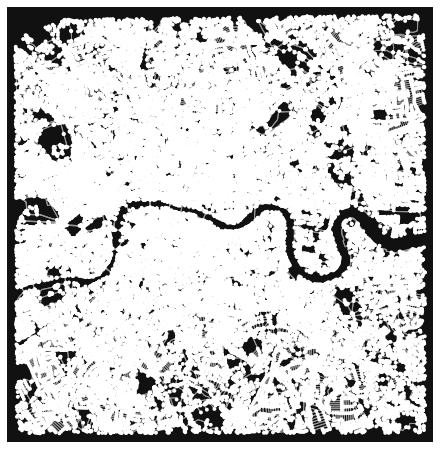

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [4]:
ox.plot_graph(G)

# Get Naive Routing between Greenwich and Camden

In [4]:
G = ox.add_edge_speeds(G) #Impute
G = ox.add_edge_travel_times(G) #Travel time

In [5]:
START = (51.49596481, 0.01243080)
END = (51.54100795, -0.14281134)
start_node = ox.get_nearest_node(G, START)
end_node = ox.get_nearest_node(G, END)

Calculate the shortest path

In [6]:
route = nx.shortest_path(G, start_node, end_node, weight='travel_time')

Plot the route and street networks

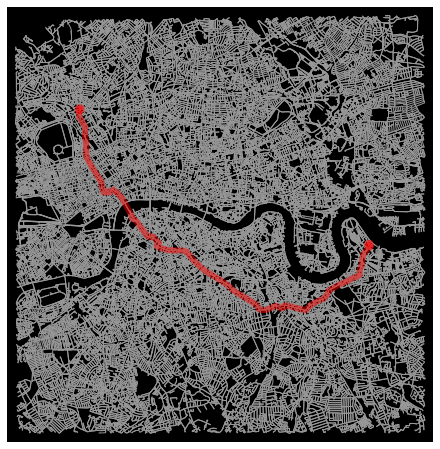

In [7]:
ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k');

# Animate Route

In [30]:
node_start = []
node_end = []
X_to = []
Y_to = []
X_from = []
Y_from = []
length = []
travel_time = []
for u, v in zip(route[:-1], route[1:]):
    node_start.append(u)
    node_end.append(v)
    length.append(round(G.edges[(u, v, 0)]['length']))
    travel_time.append(round(G.edges[(u, v, 0)]['travel_time']))
    X_from.append(G.nodes[u]['x'])
    Y_from.append(G.nodes[u]['y'])
    X_to.append(G.nodes[v]['x'])
    Y_to.append(G.nodes[v]['y'])

In [31]:
df = pd.DataFrame(list(zip(node_start, node_end, X_from, Y_from, X_to, Y_to, length, travel_time)),
                  columns = ["node_start", "node_end", "X_from", "Y_from", "X_to", "Y_to", "length", "travel_time"])
df.head()

,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time
0,4857758397,2038426428,0.012402,51.495997,0.013017,51.495504,69,8
1,2038426428,2039201992,0.013017,51.495504,0.013144,51.495531,10,1
2,2039201992,2039201999,0.013144,51.495531,0.013257,51.495444,14,2
3,2039201999,2039202006,0.013257,51.495444,0.013122,51.495359,15,2
4,2039202006,1684616938,0.013122,51.495359,0.012815,51.495179,29,3


In [32]:
def create_line_gdf(df):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_from, df.Y_from))
    gdf["geometry_to"] = [Point(xy) for xy in zip(gdf.X_to, gdf.Y_to)]
    gdf["line"] = gdf.apply(lambda row: LineString([row["geometry_to"], row["geometry"]]), axis=1)
    line_gdf = gdf[["node_start","node_end","length","travel_time", "line"]].set_geometry("line")
    return line_gdf

In [33]:
line_gdf = create_line_gdf(df)

In [34]:
start = df[df["node_start"] == start_node]
end = df[df["node_end"] == end_node]

In [35]:
px.set_mapbox_access_token(open(".mapbox_token").read())
px.scatter_mapbox(df, lon= "X_from", lat="Y_from", zoom=12)

In [40]:
fig = px.scatter_mapbox(df, lon= "X_from", lat="Y_from", 
                        zoom=13, width=1000, height=800, 
                        animation_frame=df.index, mapbox_style="dark")
fig.data[0].marker = dict(size = 12, color="black")
fig.add_trace(px.scatter_mapbox(start, lon= "X_from", lat="Y_from").data[0])
fig.data[1].marker = dict(size = 15, color="red")
fig.add_trace(px.scatter_mapbox(end, lon= "X_from", lat="Y_from").data[0])
fig.data[2].marker = dict(size = 15, color="green")
fig.add_trace(px.line_mapbox(df, lon= "X_from", lat="Y_from").data[0])
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 20
fig